In [ ]:
import time
import numpy as np
from PIL import Image
import sys
import glob
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import re

##  CONVEX OPTIMIZATION

In [ ]:
def pcp(M, delta=1e-6, mu=None, maxiter=500, missing_data=True,
        **svd_args):


    # # Check for missing data.
    shape = M.shape
    if missing_data:
        missing = ~(np.isfinite(M))
        if np.any(missing):
            M = np.array(M)
            M[missing] = 0.0
  
    # Initialize the tuning parameters.
    lam = 1.0 / np.sqrt(np.max(shape))
    if mu is None:
        mu = 0.25 * np.prod(shape) / np.sum(np.abs(M))
        print("mu = {0}".format(mu))

    # Convergence criterion.
    norm = np.sum(M ** 2)

    # Iterate.
    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)

    for i in range(maxiter):
        
        # SVD step.
        start = time.time()
        
        u ,s ,v = np.linalg.svd(M - S + Y / mu, full_matrices=False)

        # u, s, v = _svd(svd_method, M - S + Y / mu, rank+1, 1./mu, **svd_args)
        # #  _svd(method, X, rank, tol, **args):
        # np.linalg.svd(X, full_matrices=False, **args)   

        s = shrink(s, 1./mu)
        rank = np.sum(s > 0.0)
        u, s, v = u[:, :rank], s[:rank], v[:rank, :]
        L = np.dot(u, np.dot(np.diag(s), v))

        # Shrinkage step.
        S = shrink(M - L + Y / mu, lam / mu)

        # Lagrange step.
        step = M - L - S
        step[missing] = 0.0
        Y += mu * step

        # Check for convergence.
        err = np.sqrt(np.sum(step ** 2) / norm)
        iter_time = time.time() - start
        
        print(f"ITERATION -- {i}: error -- {err}, rank -- {rank}, time -- {iter_time} ")

        if err < delta:
            break

        i += 1

    return L, S


def shrink(M, tau):
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S

In [ ]:
def bitmap_to_mat(bitmap_seq):
    """from blog.shriphani.com"""
    matrix = []
    shape = None
    for bitmap_file in bitmap_seq:
        img = Image.open(bitmap_file).convert("L")
        if shape is None:
            shape = img.size
        assert img.size == shape
        img = np.array(img.getdata())
        matrix.append(img)
    return np.array(matrix), shape[::-1]

# RUN PCP
### 1 iter ~ 30sec
### dataset in the 'images' folder

In [19]:
M, shape = bitmap_to_mat(glob.glob("images/*.bmp"))
M.shape

(500, 86400)

In [18]:
L, S = pcp(M, maxiter=15)

mu = 0.001786697691745648
ITERATION -- 0: error -- 0.006760144682224081, rank -- 500, time -- 33.55356407165527 
ITERATION -- 1: error -- 0.0014893348749170374, rank -- 500, time -- 28.55592131614685 
ITERATION -- 2: error -- 0.0011090894521204441, rank -- 500, time -- 30.980406522750854 
ITERATION -- 3: error -- 0.0010073986287510556, rank -- 500, time -- 30.49988341331482 
ITERATION -- 4: error -- 0.0009565561378377716, rank -- 500, time -- 32.793487310409546 
ITERATION -- 5: error -- 0.0009128175731325857, rank -- 500, time -- 31.406973600387573 
ITERATION -- 6: error -- 0.0008702402689565003, rank -- 500, time -- 28.05792808532715 
ITERATION -- 7: error -- 0.0008284189981988746, rank -- 500, time -- 29.740821361541748 
ITERATION -- 8: error -- 0.000780144515723287, rank -- 466, time -- 30.12691640853882 
ITERATION -- 9: error -- 0.0007235143190497242, rank -- 373, time -- 31.565852642059326 
ITERATION -- 10: error -- 0.0006717982975429953, rank -- 302, time -- 29.226722955703735 
I

# STACK AND SAVE ORIG + LOW RANK + SPARSE to png

In [24]:
import os
os.getcwd()

'/content'

#### create folder for output

In [25]:
from pathlib import Path
Path(os.getcwd() + "/output/").mkdir(parents=True, exist_ok=True)

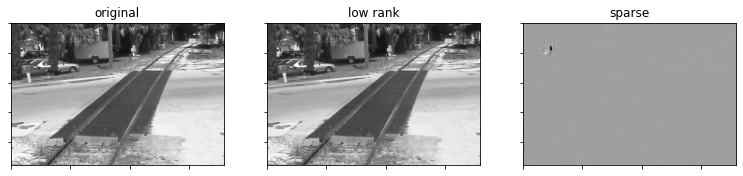

In [26]:
def do_plot(ax, img, shape):
    ax.cla()
    ax.imshow(img.reshape(shape), cmap="gray")
    ax.set_xticklabels([])
    ax.set_yticklabels([])


fig, axes = plt.subplots(1, 3, figsize=(13, 4))
for i in range(len(M)):
    do_plot(axes[0], M[i], shape)
    axes[0].set_title("original")
    do_plot(axes[1], L[i], shape)
    axes[1].set_title("low rank")
    do_plot(axes[2], S[i], shape)
    axes[2].set_title("sparse")
    fig.savefig(f"output/{i}.png")

(288, 936, 3)


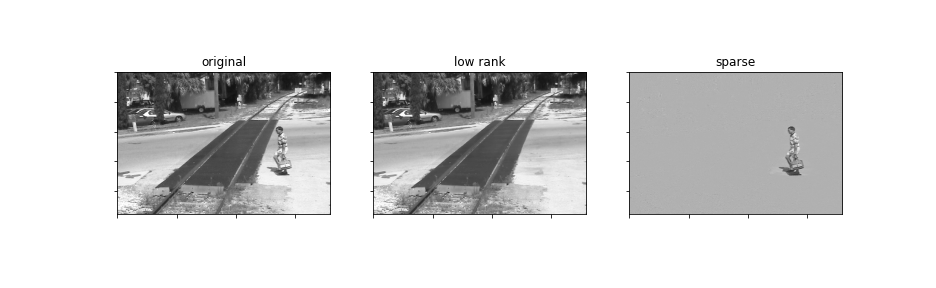

In [27]:
stacked_img = cv2.imread('output/400.png')

print(stacked_img.shape)
h, w = stacked_img.shape[:2]

cv2_imshow(stacked_img)

## sort in the correct order

In [30]:
def atoi(text):  
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

sorted_glob = sorted(glob.glob('output/*.png'),key=natural_keys)

## create video from frames

In [31]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')

out = cv2.VideoWriter('output_video.mp4', fourcc, 20.0, (w,h))

for filename in sorted_glob:
    img = cv2.imread(filename)
    out.write(img)

out.release()

## show all frames

In [32]:
# cap = cv2.VideoCapture('output_video.mp4')
# while cap.isOpened():
#     ret, image = cap.read()

#     if not ret:
#       break

#     cv2_imshow(image)

#     cv2.waitKey(1) & 0xff

# cv2.destroyAllWindows()
# cap.release()